<tr>
<td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5a/HuffPost.svg/320px-HuffPost.svg.png">
</td>
<td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Flag_of_Australia_%28converted%29.svg/320px-Flag_of_Australia_%28converted%29.svg.png">
</td>


# Analyse des sources de l'édition australienne du *Huff Post* (2015-2016) en 6 étapes faciles
<hr>

<h3 style="background:teal;color:white;padding:5px">Étape 1 - Initialisation de notre *notebook* et lecture du fichier CSV contenant nos données</h3>

In [1]:
import csv, re, random
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats, integrate
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_rows = 60
pd.options.mode.chained_assignment = None
%matplotlib inline

On lit notre fichier CSV de base, puis on crée une variable `edition` pour identifier le pays sur lequel on va travailler. La variable `huff` ne contient que les **17&nbsp;154 articles** de l'édition du pays auquel on s'intéresse ici.

In [2]:
huff = pd.read_csv("scraping-nettoye.csv", low_memory=False)
edition = "Australie"
huff = huff[huff.pays == edition]
huff.shape

(17154, 13)

Le but de cet exercice étant d'identifier le taux d'originalité du *HuffPost*, on va créer trois variables.

- `HP_oui` contiendra la proportion d'articles qui sont originaux (signés par des employés du *HuffPost* ou des pigistes).
- `HP_non` contiendra la proportion d'articles qui ne sont pas originaux (repris d'agences externes ou d'autres médias).
- `HP_inconnu` contiendra la proportion d'articles dont on ne peut pas établir la provenance.

La somme de ces trois variables équivaudra à 100. On s'en servira pour faire un graphique en pointes de tarte (camembert) à la fin.

In [3]:
HP_oui = 0
HP_non = 0
HP_inconnu = 0

<h3 style="background:teal;color:white;padding:5px">Étape 2 - Filtrer les balises <i>meta</i></h3>

<hr>
Ce ne sont pas tous les articles de cette édition qui ont, pour nom dans leurs balises `meta`, l'une ou l'autre des éditions du *Huffington Post*, ou de sa compagnie-mère, AOL

In [4]:
huff.meta.value_counts()

Huffington Post Australia       14862
The Huffington Post             1317 
ABC News                        324  
The Sydney Morning Herald       254  
Business Insider Australia      37   
news                            29   
BBC News                        27   
Huffington Post India           27   
The Age                         25   
NewsComAu                       21   
the Guardian                    18   
Brisbane Times                  17   
Fox Sports                      12   
Mail Online                     12   
ABC News Sport                  11   
Reuters                         9    
Mashable                        8    
CNN                             7    
News                            7    
Washington Post                 6    
BuzzFeed                        6    
Domain                          5    
The Times of India              5    
Stuff                           5    
Financial Review                4    
Canberra Times                  4    
cricket.com.

Créons un sous-ensemble avec les articles qui, selon la balise `meta`, semblent issus du *HP*.

In [5]:
metaHP = huff.meta.str.contains("[H,Η,h][U,u][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]", na=False)
huff[metaHP].meta.value_counts()

Huffington Post Australia       14862
The Huffington Post             1317 
Huffington Post India           27   
Huffington Post South Africa    3    
Name: meta, dtype: int64

In [6]:
huff[metaHP].shape

(16209, 13)

In [7]:
len(huff) - len(huff[metaHP])

945

Le calcul ci-haut nous indique qu'on a **945 articles** qu'on peut d'ores et déjà ranger dans la catégorie des articles qui ne sont *pas* rédigés par l'équipe du *HuffPost*.
<hr>
Examinons cependant de plus près notre sous-ensemble d'articles dont la balise `meta` prétend qu'ils sont issus du *HuffPost* en regardant qui sont les signataires de ces articles. Les signataires se trouvent dans la colonne `byline`. Voyons voir, donc, ce qu'elle contient.

<h3 style="background:teal;color:white;padding:5px">Étape 3 - Identification des articles dont les signataires sont inconnus</h3>

In [8]:
huff[metaHP].byline.value_counts()

? Associate Editor, HuffPost Australia                                                                                                                       3242
? ?                                                                                                                                                          1159
? Associate Lifestyle Editor, HuffPost Australia                                                                                                             1135
? PTI                                                                                                                                                        832 
? Head of Lifestyle, HuffPost Australia                                                                                                                      581 
? Sports And Environment Editor, HuffPost Australia                                                                                                          486 
? Associate Food Editor, Huf

Un certain nombre d'auteurs sont inconnus («&nbsp;?&nbsp;» ou «&nbsp;?&nbsp;?&nbsp;»).<br>
Ceux marqués d'un seul point d'interrogation seront placés dans la variable `inconnu1`, ceux qui sont marqués de deux points d'interrogation dans la variable `inconnu2`.<br>
Ils représentent un peu plus de **9%** du total des articles de cette édition du *Huffington&nbsp;Post*.

In [9]:
inconnus1 = huff[metaHP].byline == "? "
inconnus2 = huff[metaHP].byline == "? ?"
HP_inconnu = huff[metaHP][inconnus1].pays.count() + huff[metaHP][inconnus2].pays.count()
HP_inconnu, (HP_inconnu/len(huff))*100

(1564, 9.1174070187711322)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 4 - Identification des articles originaux au <i>HuffPost</i></h3>

Examinons maintenant les articles dont la signature contient certaines chaînes de caractères qui correspondent au *Huffington Post* (dans différentes langues, fautes de frappe incluses), ou à sa compagnie-mère, AOL. On va baptiser ce sous-ensemble `signéHP`.

In [10]:
signeHP = huff[metaHP].byline.str.contains("[H,h][U,u,f][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]",na=False)
huff[metaHP][signeHP].shape

(12236, 13)

In [11]:
huff[metaHP][signeHP].byline.value_counts(), huff[metaHP][signeHP].byline.value_counts().count()

(? Associate Editor, HuffPost Australia                                     3242
 ? Associate Lifestyle Editor, HuffPost Australia                           1135
 ? Head of Lifestyle, HuffPost Australia                                    581 
 ? Sports And Environment Editor, HuffPost Australia                        486 
 ? Associate Food Editor, HuffPost Australia                                460 
 ? Senior Associate Editor, HuffPost Australia                              396 
 ? Reporter, The Huffington Post                                            318 
 ? Politics Editor, HuffPost Australia                                      289 
 ? Entertainment Writer, The Huffington Post                                226 
 ? News Producer, HuffPost India                                            225 
 ? Senior Editor, Taste, The Huffington Post                                173 
 ? Trends Editor, The Huffington Post                                       162 
 ? Journalist, HuffPost Aust

Le *Huffington Post* est nommé, d'une façon ou d'une autre, dans ces quelque **12236 articles** signés par **267 signataires différents**.<br>
Cela représente entre les deux-tiers et les trois-quarts de l'ensemble des articles publiés par l'édition australienne du *HuffPost* dans la période étudiée.

In [12]:
HP_oui = huff[metaHP][signeHP].pays.count()
HP_oui, (HP_oui/len(huff))*100

(12236, 71.330301970385918)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 5 - Identification des articles <u>extérieurs</u> au <i>HuffPost</i></h3>

On va donc faire la même opération, mais pour tous les postes dans lesquels **on ne trouve pas** les chaînes de caractères permettant d'identifier le *Huffington&nbsp;Post* dans différentes langues. On va créer une nouvelle variable qu'on va appeler `NONsignéHP`.

In [13]:
NONsigneHP = ~huff[metaHP].byline.str.contains("[H,h][U,u,f][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]",na=False)
huff[metaHP][NONsigneHP].shape

(3973, 13)

Qui sont ces auteurs qui ne font pas partie de l'équipe du *HuffPost*?

In [14]:
huff[metaHP][NONsigneHP].byline.value_counts(), huff[metaHP][NONsigneHP].byline.value_counts().count()

(? ?                                                                                                                                                                                                      1159
 ? PTI                                                                                                                                                                                                    832 
 ?                                                                                                                                                                                                        405 
 ? Social Media Editor                                                                                                                                                                                    244 
 ? ANI                                                                                                                                                                      

Des 240 signataires ci-dessus, par contre, on trouve un certain nombre d'«&nbsp;employés fantôme&nbsp;».

Examinons, par exemple, les articles signés simplement *«&nbsp;Deputy Director, News & Analytics&nbsp;»*.

In [15]:
deputy = huff[metaHP][NONsigneHP].byline.str.contains("Deputy Director, News & Analytics")
huff[metaHP][NONsigneHP][deputy]

,code,pays,annee,mois,jour,url,titre,meta,auteur1,auteur2,tags,byline,occurences_titre
45537,XXXXX-inconnu,Australie,2015,8,19,http://www.huffingtonpost.com.au/2015/08/19/one-direction-star-liam-payne-tweets-im-not-homophobic/,One Direction Star Responds To Claims He's Homophobic | The Huffington Post,The Huffington Post,?,"Deputy Director, News & Analytics","One Direction,Liam Payne,anti gay,homophobia","? Deputy Director, News & Analytics",2
45761,XXXXX-inconnu,Australie,2015,8,28,http://www.huffingtonpost.com.au/2015/08/28/miley-cyrus-comes-out-as-pansexual/,Miley Cyrus Comes Out As Pansexual | The Huffington Post,The Huffington Post,?,"Deputy Director, News & Analytics","miley cyrus,pansexual,miley cyrus pansexual","? Deputy Director, News & Analytics",2
46264,XXXXX-inconnu,Australie,2015,9,14,http://www.huffingtonpost.com.au/2015/09/14/kristen-stewart-feels-really-bad-for-kentucky-clerk-kim-davis/,Here's Why Kristen Stewart Feels 'Really Bad' For Kim Davis | The Huffington Post,The Huffington Post,?,"Deputy Director, News & Analytics","Kristen Stewart,Kim Davis,Gay Marriage,marriage equality,tiff 2015,voices","? Deputy Director, News & Analytics",2
46740,XXXXX-inconnu,Australie,2015,9,28,http://www.huffingtonpost.com.au/2015/09/28/matt-damon-opens-up-about-gay-rumours/,"Matt Damon Opens Up About Gay Rumors, Discussing Sexuality In Hollywood | The Huffington Post",The Huffington Post,?,"Deputy Director, News & Analytics","Matt Damon,Ben Affleck,celebrity gay rumors,gay hollywood","? Deputy Director, News & Analytics",2
46920,XXXXX-inconnu,Australie,2015,10,1,http://www.huffingtonpost.com.au/2015/10/01/you-cant-unsee-trumps-man-bun/,Donald Trump With A Man Bun Is An Image You Can't Unsee | The Huffington Post,The Huffington Post,?,"Deputy Director, News & Analytics","Donald Trump,man buns,Celebrity News","? Deputy Director, News & Analytics",2
47102,XXXXX-inconnu,Australie,2015,10,7,http://www.huffingtonpost.com.au/2015/10/07/kanye-west-thinks-hes-discriminated-against-for-not-being-gay/,Kanye West Thinks He Is Discriminated Against For Not Being Gay,Huffington Post Australia,?,"Deputy Director, News & Analytics","kanye west,discrimiantion,gay issues,lgbt,Fashion","? Deputy Director, News & Analytics",1
53198,XXXXX-inconnu,Australie,2016,2,23,http://www.huffingtonpost.com.au/2016/02/23/celebrity-hairstylist-jen-atkin-helps-north-west-with-her-elsa-l/,Celebrity Hairstylist Jen Atkin Helps North West With Her Elsa Look,Huffington Post Australia,?,"Deputy Director, News & Analytics","jen atkin,North West,kim kardashian,The Kardashians,Celebrity Kids,all-pampers","? Deputy Director, News & Analytics",1
57760,XXXXX-inconnu,Australie,2016,5,19,http://www.huffingtonpost.com.au/2016/05/19/high-schoolers-beyonce-inspired-prom-dress-is-all-sorts-of-amaz/,High Schooler's Beyoncé-Inspired Prom Dress Is All Sorts Of Amazing,Huffington Post Australia,?,"Deputy Director, News & Analytics","Beyonce ,Prom,Teens,Style,Met Gala","? Deputy Director, News & Analytics",1
57783,XXXXX-inconnu,Australie,2016,5,19,http://www.huffingtonpost.com.au/2016/05/19/who-is-qualified-to-sing-at-mariah-careys-wedding-f-king-nob/,Who Is Qualified To Sing At Mariah Carey's Wedding? 'F**king Nobody',Huffington Post Australia,?,"Deputy Director, News & Analytics","Mariah Carey , James Packer,Celebrity News,Celebrity Weddings,weddings","? Deputy Director, News & Analytics",1
59407,XXXXX-inconnu,Australie,2016,7,7,http://www.huffingtonpost.com.au/2016/07/07/emily-ratajkowski-on-the-f-ed-up-beauty-ideals-put-on-young-w/,Emily Ratajkowski On The 'F***ed-Up Beauty Ideals Put On Young Women',Huffington Post Australia,?,"Deputy Director, News & Analytics","Body Image,Emily Ratajkowski,harper's bazaar,beauty ideals","? Deputy Director, News & Analytics",1


[Cet article](http://www.huffingtonpost.com.au/2016/11/13/these-photos-of-siblings-adopted-from-foster-care-are-warming-al_a_21604861/), par exemple, nous montre que la signature de cet article ne porte nulle part la mention *Huffington Post*, alors que [son auteur](http://www.huffingtonpost.com/author/cavan-sieczkowski) est clairement un employé du *HuffPost*.

C'est aussi le cas avec d'autres appellations contenant les mots *«&nbsp;Editor&nbsp;»*, notamment.

On va repérer ces signataires fantôme avec le code ci-dessous.

In [16]:
fantomes = huff[metaHP][NONsigneHP].byline.str.contains("Director|Editor[ ,i]|[R,r]eporte")
huff[metaHP][NONsigneHP][fantomes].byline.value_counts(), huff[metaHP][NONsigneHP][fantomes].byline.value_counts().sum()

(? Deputy Director, News & Analytics                                                                                                              46
 ? Entertainment Reporter                                                                                                                         35
 ? Editorial Assistant, Entertainment                                                                                                             9 
 ? Editorial Director, Parents                                                                                                                    4 
 ? Tech reporter                                                                                                                                  4 
 ? Editor of World of Knowledge Magazine                                                                                                          2 
 ? Deputy Director of Growth and Analytics                                                                

Il y en a 115, auxquels il faut cependant retrancher quelques intrus, comme *«&nbsp;Editorial Director, Parents&nbsp;»*, *«&nbsp;Editor of World of Knowledge Magazine&nbsp;»*, *«&nbsp;Editor In Chief, NowItCounts.com&nbsp;»* et quelques autres.

En retirant les 16 intrus, on se retrouve donc avec 99 auteurs fantôme du *HP*  qui devront être ajoutés à notre variable `HP_oui`.

In [17]:
HP_oui = huff[metaHP][signeHP].pays.count() + 99
HP_oui, (HP_oui/len(huff))*100

(12335, 71.907426839221174)

Il nous reste donc à calculer le pourcentage des articles signés par des auteurs externes.

Il faut ici soustraire de notre variable `NONsignéHP` les articles contenus dans les deux variables `inconnu1` et `inconnu2`, additionner les articles qu'on a identifiés au début dont la balise `meta` ne pouvait pas être associée au *HuffPost* et retrancher les auteurs fantômes qu'on a identifiés ci-dessus.

In [18]:
HP_non = huff[metaHP][NONsigneHP].pays.count() - (huff[metaHP][inconnus1].pays.count() + huff[metaHP][inconnus2].pays.count()) + (len(huff) - len(huff[metaHP])) - 99
HP_non, (HP_non/len(huff))*100

(3255, 18.975166142007698)

On a désormais tout ce qu'il nous faut pour faire le camembert évoqué plus haut.

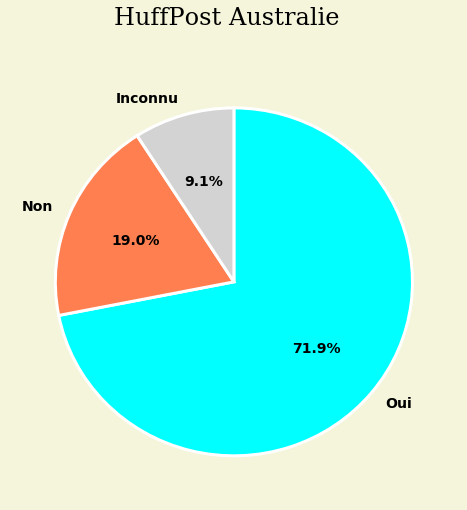

In [19]:
camembert = pd.Series([HP_oui,HP_non,HP_inconnu], index=["Oui","Non","Inconnu"],name="")
titre = plt.figure(facecolor="beige")
titre.suptitle("HuffPost Australie", fontsize=24, fontweight="light", fontname="Serif")
camembert.plot.pie(colors=["aqua","coral","lightgrey"],
                   wedgeprops={"linewidth":3,"edgecolor":"white"},
                   textprops={"weight":"bold","fontsize":14},
                   counterclock=False,
                   startangle=90,
                   autopct="%1.1f%%",
                   figsize=(8,8)
)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 6 - Dernier exercice&nbsp;: les étiquettes (<i>tags</i>)</h3>

Chaque article du *Huffington Post* est généralement accompagné d'une dizaine de marqueurs, ou d'étiquettes (*tags* en anglais). Voici ceux qui sont le plus fréquemment utilisés par l'édition australienne.

Intéressant de constater que Donald Trump apparaît plus souvent que Malcolm Turnbull, le premier ministre de l'Australie!

In [20]:
etiquettes = huff.set_index('pays').tags.str.split(',', expand=True).stack().rename(columns={0:'tag'}).reset_index(drop=True)
etiquettes.value_counts(dropna=False)

news                                  3088
in-news                               2565
politics                              1390
life                                  1157
entertainment                         1009
Politics                              728 
in-politics                           709 
video                                 688 
Now                                   682 
australia                             673 
Donald Trump                          627 
society                               624 
Life                                  538 
in-entertainment                      529 
tech                                  513 
Australia                             498 
quirk                                 488 
food                                  454 
Sport                                 426 
Food                                  417 
crime                                 386 
sport                                 378 
Entertainment                         365 
innovation 